In [1]:
import warnings

import numpy as np
import scipy.stats as stats
import scipy.special as special
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import xarray as xr
import seaborn as sns

from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.formula.api as smf
import statsmodels.api as sm

%matplotlib inline

%config InlineBackend.figure_format = 'retina'
plt.style.use("bmh")
az.rcParams["stats.hdi_prob"] = 0.89

/home/telescreen/miniconda3/envs/data/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
warnings.simplefilter('ignore', category=FutureWarning)

In [3]:
data = pd.DataFrame.from_dict(
    {
        "species": [
            "afarensis",
            "africanus",
            "habilis",
            "boisei",
            "rudolfensis",
            "ergaster",
            "sapiens",
        ],
        "brain": [438, 452, 612, 521, 752, 871, 1350],  # volume in cc
        "mass": [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5],  # mass in kg
    }
)

data

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


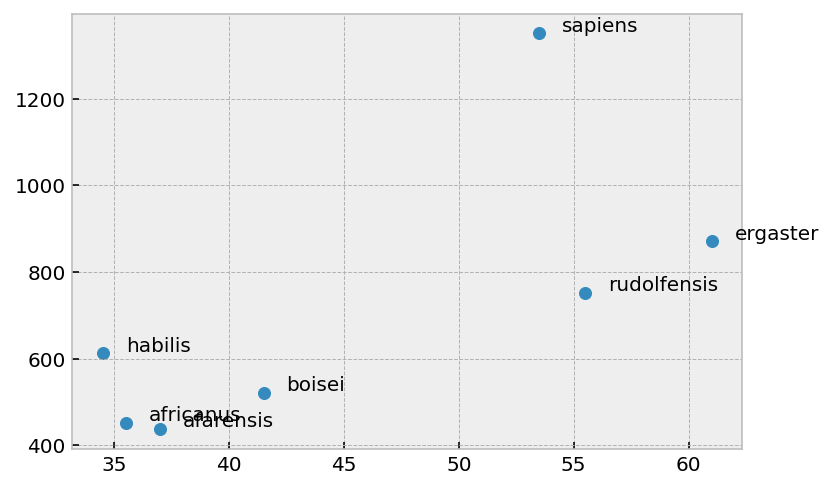

In [4]:
plt.scatter(data.mass, data.brain)
for i, txt in enumerate(data.species):
    plt.annotate(txt, (data.mass[i]+1, data.brain[i]+5))

In [5]:
data['mass_std'] = (data['mass'] - data['mass'].mean()) / data['mass'].std()
data['brain_std'] = data['brain'] / data['brain'].max()

In [6]:
def genformula(X, Y, polydeg):
    formula_array = [X]
    for i in range(2, polydeg+1):
        formula_array.append("I({}**{})".format(X, i))
    formula_str = f"{Y} ~ " + "+".join(formula_array)
    return formula_str

In [7]:
genformula('brain_std', 'mass_std', 1)

'mass_std ~ brain_std'

In [8]:
mass_new = np.linspace(30, 70, 50)
m71 = smf.ols(genformula('mass_std', 'brain_std', 1), data)
f71 = m71.fit()
pred71 = f71.get_prediction({'mass_std': mass_new})
pred = pred71.summary_frame()

/home/telescreen/miniconda3/envs/data/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1673: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


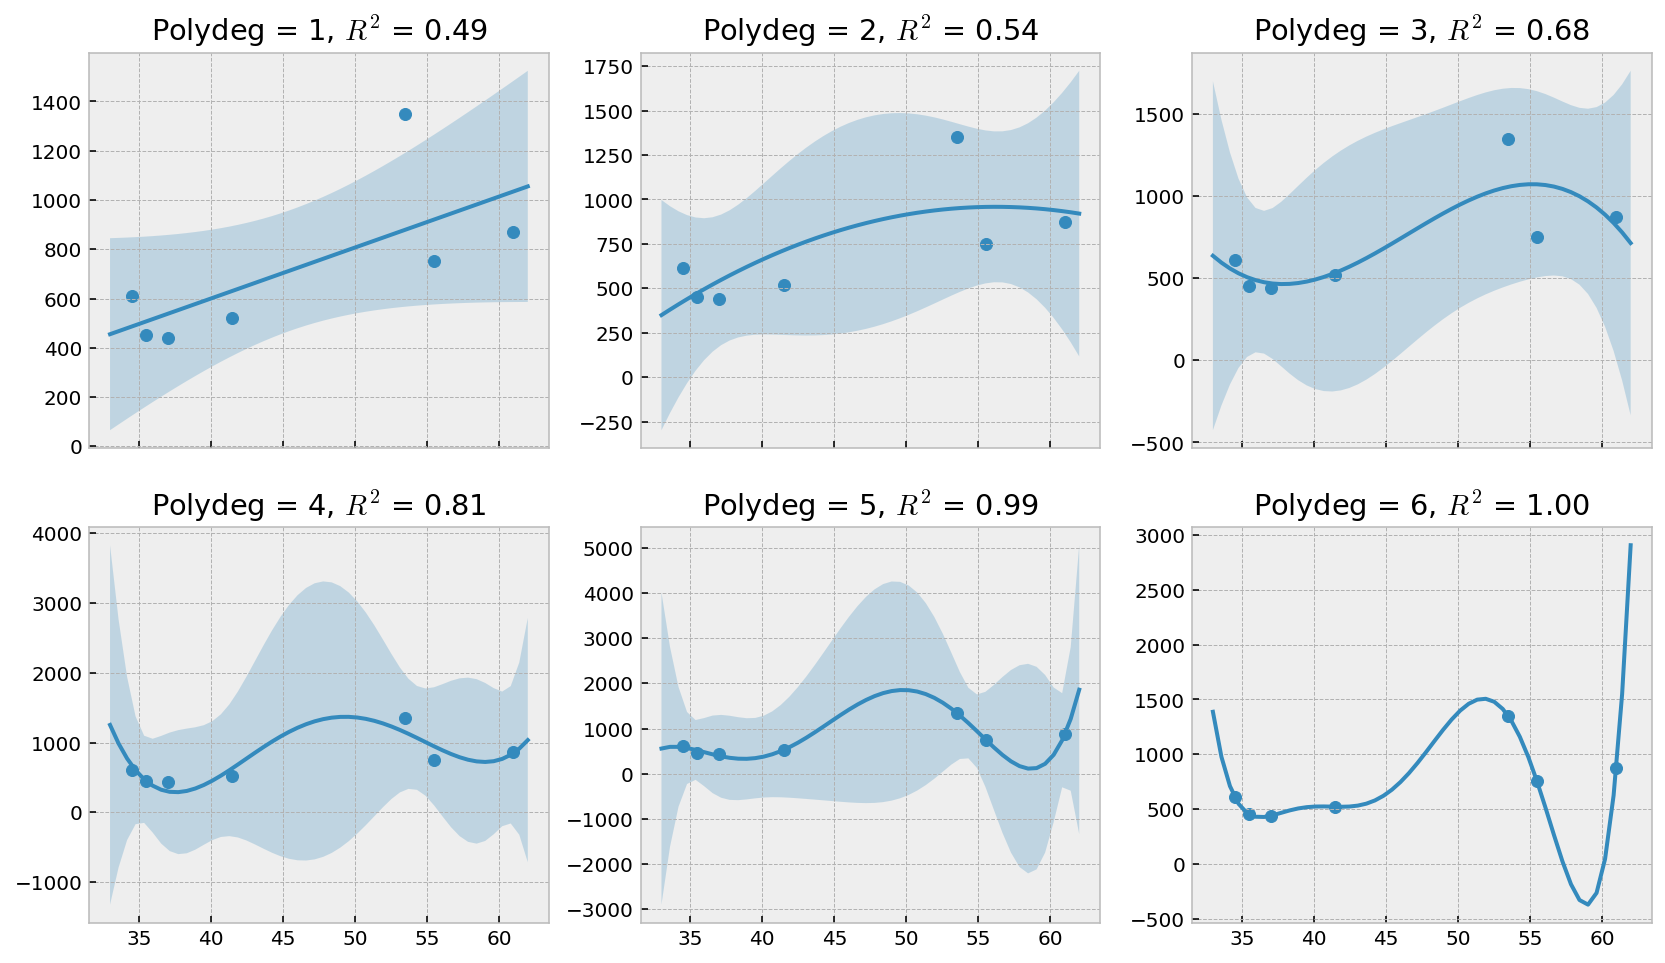

In [9]:
mass_plot = np.linspace(33, 62, 50)
mass_new = (mass_plot - data.mass.mean()) / data.mass.std()
fig, axes = plt.subplots(2, 3, figsize=(14,8), sharex=True)
for deg, ax in zip(range(1, 7), axes.flat):
    formula = genformula('mass_std', 'brain_std', deg)
    model = smf.ols(formula, data)
    fitted = model.fit()
    pred = fitted.get_prediction({'mass_std': mass_new})
    summary = pred.summary_frame()*data.brain.max()
    ax.plot(mass_plot, summary['mean'])
    ax.fill_between(mass_plot, summary['mean_ci_lower'], summary['mean_ci_upper'], alpha=0.25)
    ax.scatter(data.mass, data.brain, color='C0')
    ax.set_title(f"Polydeg = {deg}, $R^2$ = {fitted.rsquared:.2f}")

In [10]:
reg = LinearRegression()
X = data.loc[:, 'mass_std']
X = np.c_[X, X**2]
Y = data.loc[:, 'brain_std']
reg.fit(X, Y)
reg.coef_, reg.intercept_

(array([ 0.19567495, -0.09978163]), 0.6142043593046858)

In [11]:
pred = reg.predict(X)
mean_squared_error(pred, Y)

0.022661379646587595

In [12]:
m = smf.ols('brain_std ~ mass_std + I(mass_std**2)', data)
f = m.fit()
f.bse

Intercept           0.155488
mass_std            0.093130
I(mass_std ** 2)    0.158732
dtype: float64

In [13]:
p = np.tile([[.3], [.7]], (1,100))

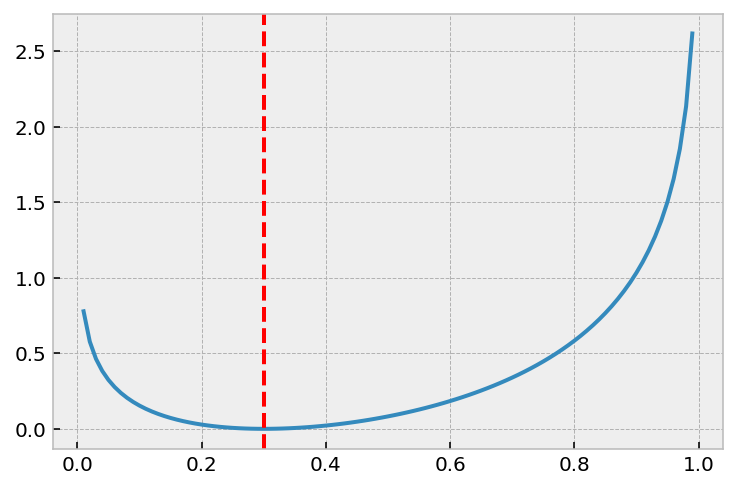

In [14]:
x = np.linspace(0.01, 1, 100)
q = stats.entropy(p, [x, 1-x])
plt.plot(x, q)
plt.axvline(x[np.argmin(q)], 0, 2.5, linestyle='--', color='r')

In [15]:
with pm.Model() as m71:
    mass = pm.Data('mass', data.mass_std)
    a = pm.Normal('a', 0.5, 1)
    b = pm.Normal('b', 0, 10)
    sigma = pm.Lognormal('sigma', 0, 2.716)
    mu = a + b*mass
    brain = pm.Normal('brain', mu, sigma, observed=data.brain_std)
    idata71 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [17]:
log_likelihood = idata71.log_likelihood.stack(dim=['chain', 'draw'])
special.logsumexp(log_likelihood.brain, axis=1) - np.log(4000)

array([ 0.51866015,  0.55464774,  0.45519645,  0.53139494,  0.37890372,
        0.34141649, -0.74962359])

In [33]:
az.waic(idata71, pointwise=True, scale='deviance').waic

/home/telescreen/miniconda3/envs/data/lib/python3.9/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


1.0905156416019177

In [34]:
s = 0
for idx, row in data.iterrows():
    mu = idata71.posterior['a'] + idata71.posterior['b']*row['mass_std']
    logbrain = stats.norm.logpdf(row['brain_std'], loc=mu, scale=idata71.posterior['sigma']).ravel()    
    lppd = special.logsumexp(logbrain) - np.log(4000)
    pwaic = logbrain.var()
    s += lppd - pwaic
print(-2*s)

1.0905156416019075
